# Курсовой проект для курса "Python для Data Science"

## Info

Материалы к проекту (файлы):
train.csv
test.csv

Задание:
Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

Целевая переменная:
Price

Основная метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Вспомогательная метрика:
MSE - средняя квадратичная ошибка (sklearn.metrics.mean_squared_error)

Сдача проекта:
1. Прислать в раздел Задания Урока 12 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).

Сроки сдачи:
Сдать проект за 72 часа до начала Урока 13 ("Вебинар. Результаты итоговых проектов и закрытие курса").

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

## Load Dataset


### Load packages

In [1]:
import pandas as pd

### Function

In [2]:
def optimizing_df(df):
    for col in df.columns:
        if df[col].dtypes.kind == 'i' or df[col].dtypes.kind == 'u':
            if df[col].min() >= 0:
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
            else:
                df[col] = pd.to_numeric(df[col], downcast='integer')

        elif df[col].dtypes.kind == 'f' or df[col].dtypes.kind == 'c':
            df[col] = pd.to_numeric(df[col], downcast='float')

        elif df[col].dtypes.kind == 'O':
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')

    return df

### Load data

In [3]:
train = pd.read_csv('Dataset/train.csv')
test = pd.read_csv('Dataset/test.csv')
print("Data is loaded!")

Data is loaded!


In [4]:
print(f"Train:\t{train.shape[0]}\t sales and {train.shape[1]} features")
print(f'Test:\t{test.shape[0]}\t sales and {test.shape[1]} features')

Train:	10000	 sales and 20 features
Test:	5000	 sales and 19 features


In [5]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [6]:
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [7]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 3.2 MB


In [8]:
test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
Id               5000 non-null int64
DistrictId       5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       3959 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null int64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null int64
Ecology_1        5000 non-null float64
Ecology_2        5000 non-null object
Ecology_3        5000 non-null object
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Healthcare_1     2623 non-null float64
Helthcare_2      5000 non-null int64
Shops_1          5000 non-null int64
Shops_2          5000 non-null object
dtypes: float64(7), int64(9), object(3)
memory usage: 1.6 MB


### Memory use optimization

In [9]:
train['Rooms'] = train['Rooms'].astype('int64')
test['Rooms'] = test['Rooms'].astype('int64')

In [10]:
train['HouseFloor'] = train['HouseFloor'].astype('int64')
test['HouseFloor'] = test['HouseFloor'].astype('int64')

In [11]:
train = optimizing_df(train)
test = optimizing_df(test)

In [12]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null uint16
DistrictId       10000 non-null uint8
Rooms            10000 non-null uint8
Square           10000 non-null float32
LifeSquare       7887 non-null float32
KitchenSquare    10000 non-null float32
Floor            10000 non-null uint8
HouseFloor       10000 non-null uint8
HouseYear        10000 non-null uint32
Ecology_1        10000 non-null float32
Ecology_2        10000 non-null category
Ecology_3        10000 non-null category
Social_1         10000 non-null uint8
Social_2         10000 non-null uint16
Social_3         10000 non-null uint8
Healthcare_1     5202 non-null float32
Helthcare_2      10000 non-null uint8
Shops_1          10000 non-null uint8
Shops_2          10000 non-null category
Price            10000 non-null float32
dtypes: category(3), float32(6), uint16(2), uint32(1), uint8(8)
memory usage: 420.6 KB


In [13]:
test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
Id               5000 non-null uint16
DistrictId       5000 non-null uint8
Rooms            5000 non-null uint8
Square           5000 non-null float32
LifeSquare       3959 non-null float32
KitchenSquare    5000 non-null float32
Floor            5000 non-null uint8
HouseFloor       5000 non-null uint8
HouseYear        5000 non-null uint16
Ecology_1        5000 non-null float32
Ecology_2        5000 non-null category
Ecology_3        5000 non-null category
Social_1         5000 non-null uint8
Social_2         5000 non-null uint16
Social_3         5000 non-null uint8
Healthcare_1     2623 non-null float32
Helthcare_2      5000 non-null uint8
Shops_1          5000 non-null uint8
Shops_2          5000 non-null category
dtypes: category(3), float32(5), uint16(3), uint8(8)
memory usage: 181.4 KB


### Data checking

#### Function

In [14]:
def prepare_lifesquare(df):
    df.loc[df['Square'] < df['LifeSquare'], 'LifeSquare'] = df['Square']
    return df


def fillna_life_square(df, source_df):
    df['LifeSquare'] = df['LifeSquare'].fillna(source_df['LifeSquare'].mean())
    return df

In [15]:
all_data = pd.concat((train, test), sort=False).reset_index(drop=True)
all_data.drop(['Price'], axis=1, inplace=True)
print(f'all_data size is : {all_data.shape}')

all_data size is : (15000, 19)


In [16]:
all_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,15000.0,8393.136933,4850.111673,0.000000,4188.750000,8378.500000,12594.250000,1.679800e+04
DistrictId,15000.0,50.693600,43.786257,0.000000,20.000000,37.000000,75.000000,2.120000e+02
Rooms,15000.0,1.897000,0.839229,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,15000.0,56.360352,20.423912,1.136859,41.814370,52.645758,66.036606,6.410652e+02
LifeSquare,11846.0,36.851791,71.120186,0.333490,22.896130,32.822811,45.144627,7.480592e+03
KitchenSquare,15000.0,6.174467,24.016979,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,15000.0,8.561800,5.323113,1.000000,4.000000,7.000000,12.000000,7.800000e+01
HouseFloor,15000.0,12.606600,6.780165,0.000000,9.000000,12.000000,17.000000,1.170000e+02
HouseYear,15000.0,3321.575067,163707.780381,1908.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,15000.0,0.119196,0.119371,0.000000,0.017647,0.075424,0.195781,5.218670e-01


#### Square

In [17]:
train = prepare_lifesquare(train)
train = fillna_life_square(train, train)

#### HouseYear

In [18]:
all_data.loc[all_data['HouseYear'] > 2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
1497,10814,109,1,37.265072,20.239714,9.0,9,12,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B
4189,11607,147,2,44.791836,28.360394,5.0,4,9,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B


In [19]:
train.loc[train['HouseYear'] > 2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1497,10814,109,1,37.265072,20.239714,9.0,9,12,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B,254084.531250
4189,11607,147,2,44.791836,28.360394,5.0,4,9,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B,243028.609375


In [20]:
test.loc[test['HouseYear'] > 2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2


In [21]:
train.loc[train['HouseYear'] == 20052011, 'HouseYear'] = int((2005 + 2011)/2)

In [22]:
train.loc[train['HouseYear'] == 4968, 'HouseYear'] = 1968

## Data Processing

### Load packages

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

%matplotlib inline
# %config InlineBackend.figure_format = 'svg'

### Target Variable¶

#### Normal distribution of the target variable

mu = 214138.86 and sigma = 92867.65


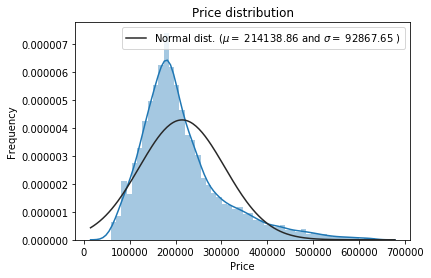

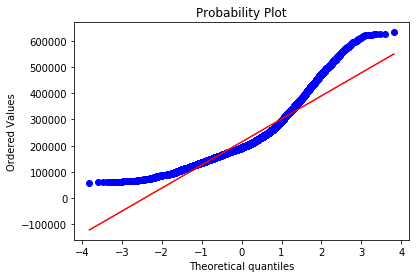

In [24]:
sns.distplot(train['Price'], fit=norm)

mu, sigma = norm.fit(train['Price'])

print(f'mu = {mu:.2f} and sigma = {sigma:.2f}')

plt.legend(
    [f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'], loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

# QQ-plot
fig = plt.figure()
res = stats.probplot(train['Price'], plot=plt)
plt.show()

#### Log distribution of the target variable

mu = 214138.86 and sigma = 92867.65


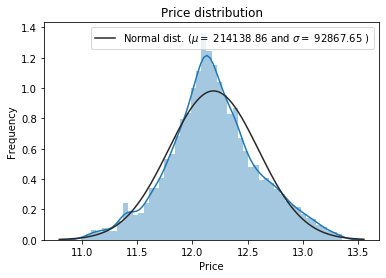

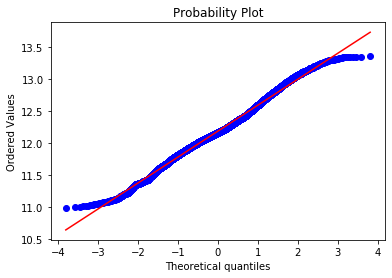

In [25]:
price_log = np.log1p(train['Price'])
sns.distplot(price_log, fit=norm)

mu, sigma = norm.fit(train['Price'])

print(f'mu = {mu:.2f} and sigma = {sigma:.2f}')

plt.legend(
    [f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'], loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

# QQ-plot
fig = plt.figure()
res = stats.probplot(price_log, plot=plt)
plt.show()

### Distribution of variable House Year

Text(0.5, 1.0, 'Distribution of variable House Year')

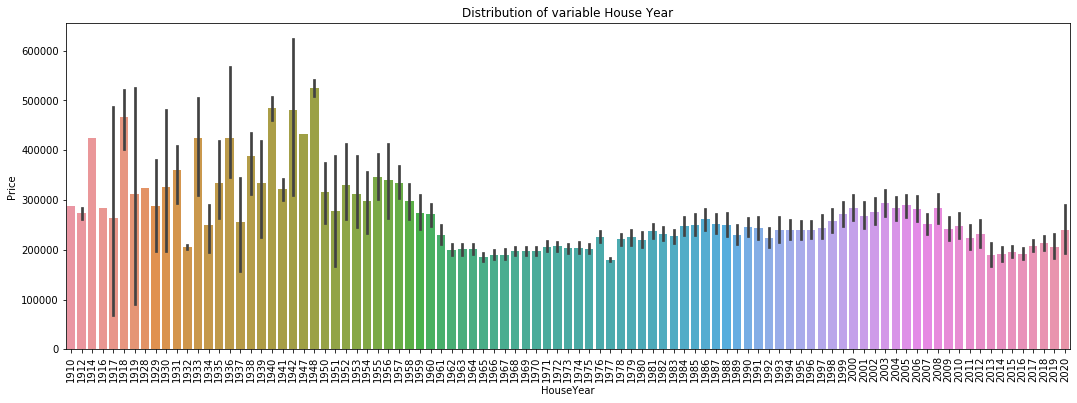

In [26]:
plt.figure(figsize=(18, 6))
sns.barplot(train['HouseYear'], train['Price'])
plt.xticks(rotation=90)
plt.title('Distribution of variable House Year')

### Distribution of variable District Id 

Text(0.5, 1.0, 'Distribution of variable District Id')

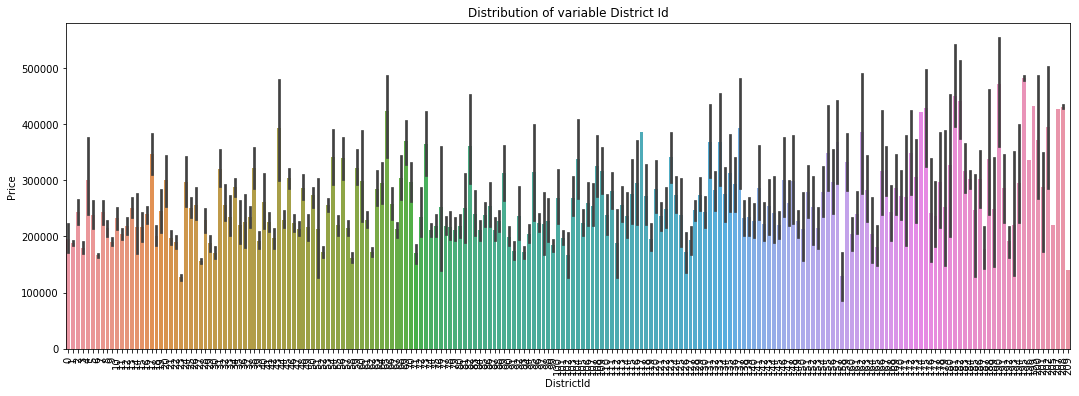

In [27]:
plt.figure(figsize=(18, 6))
sns.barplot(train['DistrictId'], train['Price'])
plt.xticks(rotation=90)
plt.title('Distribution of variable District Id')

### Features engineering

#### Missing Data

In [28]:
all_data = pd.concat((train, test), sort=False).reset_index(drop=True)
all_data.drop(['Price'], axis=1, inplace=True)
print(f'all_data size is : {all_data.shape}')

all_data size is : (15000, 19)


In [29]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(
    all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio': all_data_na})
missing_data

,Missing Ratio
Healthcare_1,47.833333
LifeSquare,6.940000


#### Data Correlation

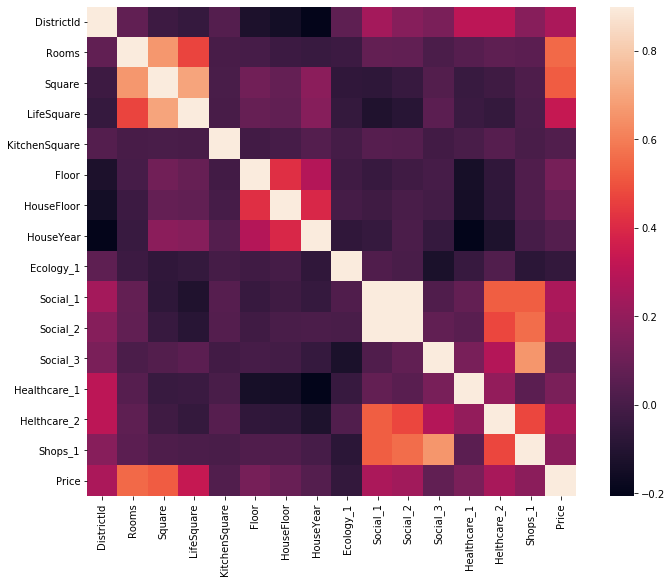

In [30]:
corrmat = train.loc[:, train.columns != 'Id'].corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=0.9, square=True)

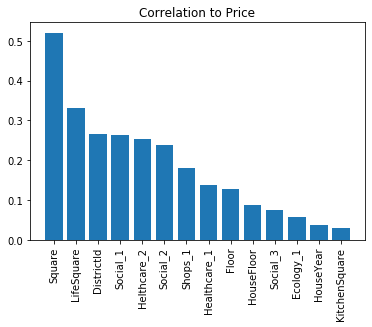

In [31]:
corrmat = train.loc[:, train.columns != 'Id'].corrwith(
    train['Price']).abs().sort_values(ascending=False)[2:]
plt.bar(corrmat.index, corrmat.values)
plt.title('Correlation to Price')
plt.xticks(rotation='vertical')
plt.show()

#### Dummy variables

In [32]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [33]:
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,725,58,2,49.882645,33.432781,6.0,6,14,1972,0.310199,...,1,NaN,0,0,0,1,0,1,0,1
1,15856,74,2,69.263184,NaN,1.0,6,1,1977,0.075779,...,3,NaN,0,2,0,1,0,1,0,1
2,5480,190,1,13.597818,15.948246,12.0,2,5,1909,0.000000,...,87,4702.0,5,5,0,1,0,1,0,1
3,15664,47,2,73.046608,51.940842,9.0,22,22,2007,0.101872,...,3,NaN,3,3,0,1,0,1,0,1
4,14275,27,1,47.527111,43.387569,1.0,17,17,2017,0.072158,...,1,NaN,0,0,0,1,0,1,1,0


#### Cluster

In [34]:
scaler = MinMaxScaler()

In [35]:
train_scaled = pd.DataFrame(scaler.fit_transform(
    train.loc[:, ['HouseYear', 'Price']]), columns=['HouseYear', 'Price'])
test_scaled = pd.DataFrame(scaler.fit_transform(
    test.loc[:, ['HouseYear']]), columns=['HouseYear'])

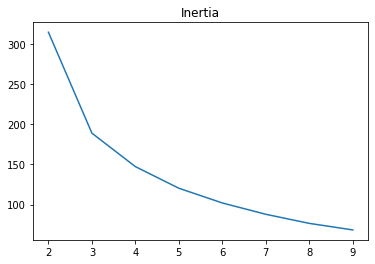

In [36]:
inertias = []

for i in range(2, 10):
    temp_model = KMeans(n_clusters=i, random_state=100)
    temp_model.fit(train_scaled)
    temp_inertia = temp_model.inertia_
    inertias.append(temp_inertia)

plt.plot(range(2, 10), inertias)
plt.title('Inertia')

plt.show()

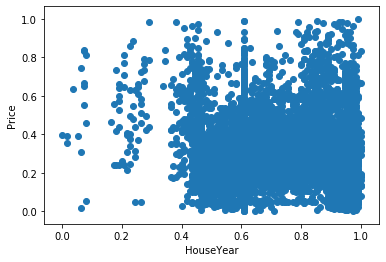

In [37]:
plt.scatter(train_scaled['HouseYear'], train_scaled['Price'])
plt.xlabel('HouseYear')
plt.ylabel('Price')
plt.show()

In [38]:
kmeans_model = KMeans(n_clusters=5, random_state=100)

In [39]:
train_labels = kmeans_model.fit_predict(train_scaled)

Text(0.5, 1.0, 'Train data')

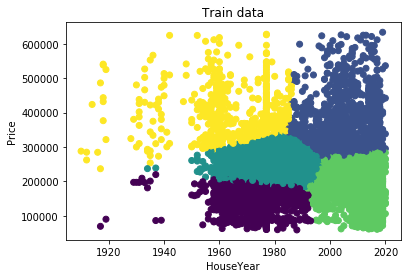

In [40]:
plt.scatter(train['HouseYear'], train['Price'], c=train_labels)

plt.xlabel('HouseYear')
plt.ylabel('Price')

plt.title('Train data')

In [41]:
agglomerative_clustering_model = AgglomerativeClustering(n_clusters=5)

In [42]:
train['cluster_year'] = agglomerative_clustering_model.fit_predict(
    train_scaled)

Text(0.5, 1.0, 'Train')

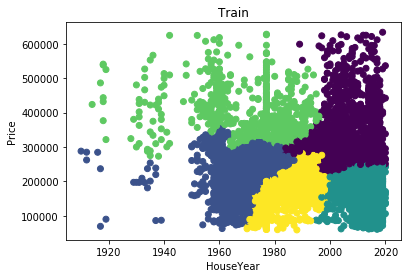

In [43]:
plt.scatter(train['HouseYear'], train['Price'], c=train['cluster_year'])
plt.xlabel('HouseYear')
plt.ylabel('Price')
plt.title('Train')

In [44]:
test['cluster_year'] = agglomerative_clustering_model.fit_predict(test_scaled)

#### Mean price by Rooms and Mean price by DistrictId and Rooms

In [45]:
price = train['Price'].mean()
price_mean_by_rooms = train.groupby(['Rooms'], as_index=False).agg({'Price': 'mean'}).\
    rename(columns={'Price': 'mean_price_by_rooms'})
price_mean_by_distr_rooms = train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price': 'mean'}).\
    rename(columns={'Price': 'mean_price_dr'})

In [46]:
price_mean_by_rooms.head()

,Rooms,mean_price_by_rooms
0,0,200435.890625
1,1,159850.796875
2,2,215256.312500
3,3,289337.968750
4,4,383251.093750


In [47]:
price_mean_by_distr_rooms.head()

,DistrictId,Rooms,mean_price_dr
0,0,1,141262.609375
1,0,2,197998.140625
2,0,3,304170.531250
3,1,1,147454.609375
4,1,2,198777.281250


In [48]:
def add_mean_price(df, price_mean_by_distr_rooms, price_mean_by_rooms, price):
    df = pd.merge(df, price_mean_by_distr_rooms, on=[
                  'DistrictId', 'Rooms'], how='left')
    df = pd.merge(df, price_mean_by_rooms, on='Rooms', how='left')
    df['mean_price_dr'] = df['mean_price_dr'].fillna(df['mean_price_by_rooms'])
    df['mean_price_dr'] = df['mean_price_dr'].fillna(price)
    df['mean_price_by_rooms'] = df['mean_price_by_rooms'].fillna(price)
    return df

#### Large district

In [49]:
distr_info1 = train['DistrictId'].value_counts().reset_index().\
    rename(columns={"index": "DistrictId", "DistrictId": 'large_district'})

In [50]:
distr_info1.head()

,DistrictId,large_district
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [51]:
def add_distr_info(df, distr_info1):
    df = pd.merge(df, distr_info1, on='DistrictId', how='left')
    df['large_district'] = df['large_district'].fillna(1)
    return df

## Modelling

### Load packages

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LassoCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split

###  Data processing

In [53]:
train = add_mean_price(train, price_mean_by_distr_rooms,
                       price_mean_by_rooms, price)
test = add_mean_price(test, price_mean_by_distr_rooms,
                      price_mean_by_rooms, price)

In [54]:
train = add_distr_info(train, distr_info1)
test = add_distr_info(test, distr_info1)

In [55]:
print(train.columns)

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
       'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Price',
       'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A',
       'Shops_2_B', 'cluster_year', 'mean_price_dr', 'mean_price_by_rooms',
       'large_district'],
      dtype='object')


In [56]:
features = ['DistrictId',
            'Rooms',
            'Square',
            'LifeSquare',
            'KitchenSquare',
            'Floor',
            'HouseFloor',
            'HouseYear',
            'Ecology_1',
            'Social_1',
            'Social_2',
            'Social_3',
            'Helthcare_2',
            'Shops_1',
            'Ecology_2_A',
            'Ecology_2_B',
            'Ecology_3_A',
            'Ecology_3_B',
            'Shops_2_A',
            'Shops_2_B',
            'mean_price_dr',
            'mean_price_by_rooms',
            'cluster_year',
            'large_district'
            ]

target = 'Price'

In [57]:
models_dict = {}

In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    train[features], train[target], test_size=0.3, random_state=42)

### Function

In [59]:
def model_test(model, name='', test=X_test, valid=y_test):
    model_pred = model.predict(test)
    r2 = r2_score(valid, model_pred)
    mse = mean_squared_error(valid, model_pred)
    plt.scatter(valid, (model_pred - valid))
    plt.xlabel("Predicted values")
    plt.ylabel("Real values")
    plt.title(name)
    plt.legend([f'R2= {r2:.4f} and mse= {mse:.0f}'])
    plt.axhline(0, color='red')
    plt.show()


def model_top_deviation(model, test=X_test, valid=y_test):
    model_pred = model.predict(test)
    model_test = test.copy()
    model_test['Price'] = model_pred.astype('int32')
    model_test['Price_test'] = valid.astype('int32')
    model_test['SD'] = abs(model_test['Price']
                           - model_test['Price_test']).astype('int32')
    return model_test.nlargest(10, 'SD')

### Linear Regression

In [60]:
line_regression_model = LinearRegression(normalize=True)
line_regression_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [61]:
models_dict['Linear Regression'] = line_regression_model

#### Test Linear Regression

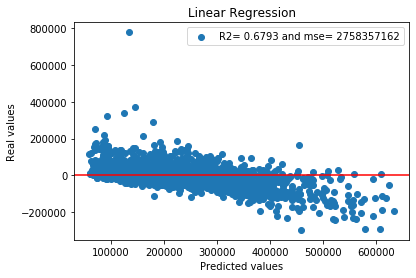

In [62]:
model_test(line_regression_model, 'Linear Regression')

In [63]:
model_top_deviation(line_regression_model)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Ecology_3_B,Shops_2_A,Shops_2_B,mean_price_dr,mean_price_by_rooms,cluster_year,large_district,Price,Price_test,SD
6977,30,2,641.065186,638.163208,10.0,20,19,2019,0.000078,22,...,1,0,1,175411.640625,215256.312500,2,228,912896,133529,779367
132,108,3,110.203972,59.270702,12.0,19,28,2007,0.019509,37,...,1,0,1,454956.937500,289337.968750,2,27,517632,146061,371571
3662,54,3,101.279846,52.188698,20.0,20,37,2014,0.006076,30,...,1,0,1,406272.531250,289337.968750,2,37,465408,124844,340564
9488,59,3,85.289093,51.296257,10.0,13,25,2011,0.309479,35,...,1,0,1,400943.031250,289337.968750,2,67,414720,92295,322425
8283,34,1,1.988943,1.988943,1.0,21,4,1977,0.069753,53,...,1,0,1,204809.359375,159850.796875,3,111,161280,458378,297098
8088,119,2,91.713600,47.760426,11.0,11,24,2001,0.000995,42,...,1,0,1,203318.734375,215256.312500,0,49,285696,578626,292930
3305,66,3,78.747856,33.885761,11.0,2,5,1955,0.161976,31,...,0,0,1,338540.718750,289337.968750,3,62,314368,606958,292590
7728,24,3,126.621361,62.455482,12.0,22,48,2011,0.111627,50,...,1,0,1,361843.250000,289337.968750,2,35,467968,179396,288572
696,113,3,94.417145,56.749168,11.0,6,18,2008,0.050756,24,...,1,0,1,296753.062500,289337.968750,2,41,321536,71057,250479
8824,30,1,117.370743,102.187202,6.0,14,40,2011,0.000078,22,...,1,0,1,138446.187500,159850.796875,0,228,281088,521829,240741


### Random Forest Regressor

In [64]:
random_forest_regressor_model = RandomForestRegressor(
    n_estimators=40, max_depth=10, random_state=42)
random_forest_regressor_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=40,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [65]:
models_dict['Random Forest Regressor'] = random_forest_regressor_model

#### Test Random Forest Regressor

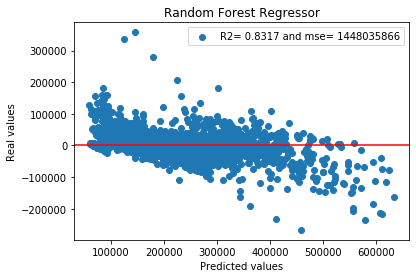

In [66]:
model_test(random_forest_regressor_model, 'Random Forest Regressor')

In [67]:
model_top_deviation(random_forest_regressor_model)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Ecology_3_B,Shops_2_A,Shops_2_B,mean_price_dr,mean_price_by_rooms,cluster_year,large_district,Price,Price_test,SD
132,108,3,110.203972,59.270702,12.0,19,28,2007,0.019509,37,...,1,0,1,454956.937500,289337.968750,2,27,503825,146061,357764
3662,54,3,101.279846,52.188698,20.0,20,37,2014,0.006076,30,...,1,0,1,406272.531250,289337.968750,2,37,462466,124844,337622
7728,24,3,126.621361,62.455482,12.0,22,48,2011,0.111627,50,...,1,0,1,361843.250000,289337.968750,2,35,458538,179396,279142
8283,34,1,1.988943,1.988943,1.0,21,4,1977,0.069753,53,...,1,0,1,204809.359375,159850.796875,3,111,191692,458378,266686
8088,119,2,91.713600,47.760426,11.0,11,24,2001,0.000995,42,...,1,0,1,203318.734375,215256.312500,0,49,344301,578626,234325
6838,33,1,60.222343,36.048752,1.0,21,25,1977,0.236108,16,...,1,0,1,180837.406250,159850.796875,3,31,179331,411959,232628
9828,24,3,127.141144,4.811405,1.0,3,1,2017,0.111627,50,...,1,0,1,361843.250000,289337.968750,0,35,395007,611250,216243
3305,66,3,78.747856,33.885761,11.0,2,5,1955,0.161976,31,...,0,0,1,338540.718750,289337.968750,3,62,395259,606958,211699
6117,17,3,54.036552,43.891273,8.0,6,21,2017,0.093443,23,...,1,0,1,419768.781250,289337.968750,0,59,349516,556053,206537
9765,45,3,82.193428,36.048752,1.0,17,17,1977,0.195781,23,...,1,0,1,393951.531250,289337.968750,1,116,430574,224868,205706


### Gradient Boosting Regressor

In [68]:
gradient_boosting_regressor_model = GradientBoostingRegressor()
gradient_boosting_regressor_model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [69]:
models_dict['Gradient Boosting Regressor'] = gradient_boosting_regressor_model

#### Test Gradient Boosting Regressor

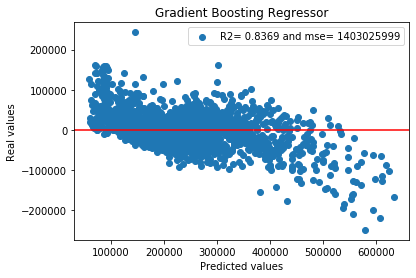

In [70]:
model_test(gradient_boosting_regressor_model, 'Gradient Boosting Regressor')

In [71]:
model_top_deviation(gradient_boosting_regressor_model)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Ecology_3_B,Shops_2_A,Shops_2_B,mean_price_dr,mean_price_by_rooms,cluster_year,large_district,Price,Price_test,SD
8088,119,2,91.713600,47.760426,11.0,11,24,2001,0.000995,42,...,1,0,1,203318.734375,215256.312500,0,49,329013,578626,249613
132,108,3,110.203972,59.270702,12.0,19,28,2007,0.019509,37,...,1,0,1,454956.937500,289337.968750,2,27,389415,146061,243354
3305,66,3,78.747856,33.885761,11.0,2,5,1955,0.161976,31,...,0,0,1,338540.718750,289337.968750,3,62,388242,606958,218716
6117,17,3,54.036552,43.891273,8.0,6,21,2017,0.093443,23,...,1,0,1,419768.781250,289337.968750,0,59,346587,556053,209466
1918,63,1,127.651237,2.609712,1.0,8,17,2016,0.238617,26,...,1,0,1,253604.218750,159850.796875,0,43,393852,594565,200713
2554,190,2,47.489414,35.564480,4.0,5,5,1918,0.000000,30,...,1,0,1,370810.750000,215256.312500,3,7,341931,537979,196048
4373,66,2,74.418358,70.893913,9.0,15,17,2003,0.111627,50,...,1,0,1,256642.000000,215256.312500,0,62,353900,538574,184674
7447,23,3,78.062851,36.048752,1.0,14,17,2017,0.014334,2,...,1,0,1,170912.203125,289337.968750,0,565,253457,431238,177781
8546,43,2,55.637753,32.077202,9.0,2,5,1958,0.000078,22,...,1,0,1,425187.000000,215256.312500,3,9,379832,552515,172683
6794,73,2,73.210350,36.048752,1.0,16,17,2019,0.042032,37,...,1,0,1,387505.406250,215256.312500,0,17,466496,633233,166737


### LassoCV

In [72]:
lasso_cv_model = LassoCV()

lasso_cv_model.fit(X_train, y_train)

/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [73]:
models_dict['LassoCV'] = lasso_cv_model

#### Test LassoCV

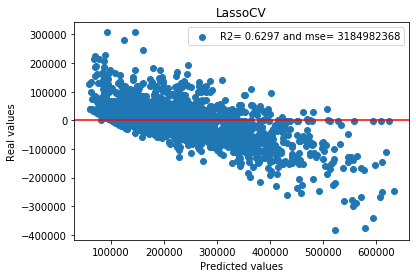

In [74]:
model_test(lasso_cv_model, 'LassoCV')

In [75]:
model_top_deviation(lasso_cv_model)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Ecology_3_B,Shops_2_A,Shops_2_B,mean_price_dr,mean_price_by_rooms,cluster_year,large_district,Price,Price_test,SD
8824,30,1,117.370743,102.187202,6.0,14,40,2011,0.000078,22,...,1,0,1,138446.187500,159850.796875,0,228,138884,521829,382945
8088,119,2,91.713600,47.760426,11.0,11,24,2001,0.000995,42,...,1,0,1,203318.734375,215256.312500,0,49,203387,578626,375239
1918,63,1,127.651237,2.609712,1.0,8,17,2016,0.238617,26,...,1,0,1,253604.218750,159850.796875,0,43,253387,594565,341178
9488,59,3,85.289093,51.296257,10.0,13,25,2011,0.309479,35,...,1,0,1,400943.031250,289337.968750,2,67,399889,92295,307594
132,108,3,110.203972,59.270702,12.0,19,28,2007,0.019509,37,...,1,0,1,454956.937500,289337.968750,2,27,453595,146061,307534
7516,58,3,103.024529,57.295414,14.0,18,24,2005,0.050756,24,...,1,0,1,257313.671875,289337.968750,0,179,257076,557202,300126
8921,94,3,108.957283,51.063721,27.0,2,22,2008,0.282798,33,...,1,0,1,274419.875000,289337.968750,0,89,274084,562559,288475
4373,66,2,74.418358,70.893913,9.0,15,17,2003,0.111627,50,...,1,0,1,256642.000000,215256.312500,0,62,256408,538574,282166
3662,54,3,101.279846,52.188698,20.0,20,37,2014,0.006076,30,...,1,0,1,406272.531250,289337.968750,2,37,405188,124844,280344
5425,85,3,121.617058,36.048752,1.0,4,17,2016,0.037178,52,...,1,0,1,277434.468750,289337.968750,0,76,277082,554809,277727


### LGBMRegressor

In [76]:
lgbm_regressor_model = LGBMRegressor()
lgbm_regressor_model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [77]:
models_dict['LGBMRegressor'] = lgbm_regressor_model

#### Test LGBMRegressor

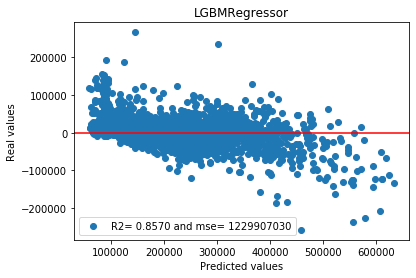

In [78]:
model_test(lgbm_regressor_model, 'LGBMRegressor')

In [79]:
model_top_deviation(lgbm_regressor_model)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Ecology_3_B,Shops_2_A,Shops_2_B,mean_price_dr,mean_price_by_rooms,cluster_year,large_district,Price,Price_test,SD
132,108,3,110.203972,59.270702,12.0,19,28,2007,0.019509,37,...,1,0,1,454956.937500,289337.968750,2,27,412919,146061,266858
8283,34,1,1.988943,1.988943,1.0,21,4,1977,0.069753,53,...,1,0,1,204809.359375,159850.796875,3,111,200341,458378,258037
6117,17,3,54.036552,43.891273,8.0,6,21,2017,0.093443,23,...,1,0,1,419768.781250,289337.968750,0,59,319992,556053,236061
7375,2,3,117.237801,62.361488,17.0,2,15,2008,0.035145,42,...,1,0,1,342699.343750,289337.968750,0,78,537690,302416,235274
8088,119,2,91.713600,47.760426,11.0,11,24,2001,0.000995,42,...,1,0,1,203318.734375,215256.312500,0,49,352660,578626,225966
3305,66,3,78.747856,33.885761,11.0,2,5,1955,0.161976,31,...,0,0,1,338540.718750,289337.968750,3,62,399572,606958,207386
3000,137,2,64.877319,38.682858,8.0,8,8,1956,0.200147,23,...,1,0,1,229068.046875,215256.312500,1,9,285024,90930,194094
3662,54,3,101.279846,52.188698,20.0,20,37,2014,0.006076,30,...,1,0,1,406272.531250,289337.968750,2,37,311694,124844,186850
6838,33,1,60.222343,36.048752,1.0,21,25,1977,0.236108,16,...,1,0,1,180837.406250,159850.796875,3,31,225640,411959,186319
7447,23,3,78.062851,36.048752,1.0,14,17,2017,0.014334,2,...,1,0,1,170912.203125,289337.968750,0,565,247824,431238,183414


### XGBRegressor

In [80]:
xgboost_model = XGBRegressor()
xgboost_model.fit(X_train, y_train)

/usr/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:26:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [81]:
models_dict['XGBRegressor'] = xgboost_model

#### Test XGBRegressor

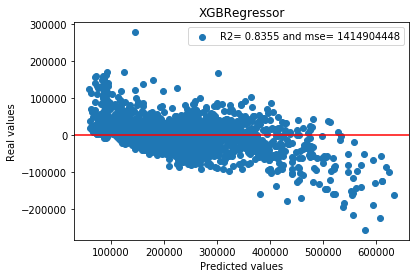

In [82]:
model_test(xgboost_model, 'XGBRegressor')

In [83]:
model_top_deviation(xgboost_model)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Ecology_3_B,Shops_2_A,Shops_2_B,mean_price_dr,mean_price_by_rooms,cluster_year,large_district,Price,Price_test,SD
132,108,3,110.203972,59.270702,12.0,19,28,2007,0.019509,37,...,1,0,1,454956.937500,289337.968750,2,27,424187,146061,278126
8088,119,2,91.713600,47.760426,11.0,11,24,2001,0.000995,42,...,1,0,1,203318.734375,215256.312500,0,49,322462,578626,256164
3305,66,3,78.747856,33.885761,11.0,2,5,1955,0.161976,31,...,0,0,1,338540.718750,289337.968750,3,62,384147,606958,222811
6117,17,3,54.036552,43.891273,8.0,6,21,2017,0.093443,23,...,1,0,1,419768.781250,289337.968750,0,59,339459,556053,216594
2554,190,2,47.489414,35.564480,4.0,5,5,1918,0.000000,30,...,1,0,1,370810.750000,215256.312500,3,7,342678,537979,195301
1918,63,1,127.651237,2.609712,1.0,8,17,2016,0.238617,26,...,1,0,1,253604.218750,159850.796875,0,43,405887,594565,188678
4373,66,2,74.418358,70.893913,9.0,15,17,2003,0.111627,50,...,1,0,1,256642.000000,215256.312500,0,62,355098,538574,183476
7447,23,3,78.062851,36.048752,1.0,14,17,2017,0.014334,2,...,1,0,1,170912.203125,289337.968750,0,565,254419,431238,176819
3662,54,3,101.279846,52.188698,20.0,20,37,2014,0.006076,30,...,1,0,1,406272.531250,289337.968750,2,37,294827,124844,169983
9488,59,3,85.289093,51.296257,10.0,13,25,2011,0.309479,35,...,1,0,1,400943.031250,289337.968750,2,67,262032,92295,169737


## Result

### Load packages

In [84]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

### Function

In [85]:
def models_r2(models, test, valid):
    scores = pd.DataFrame(columns=['name', 'r2', 'mse'])
    for name, model in models.items():
        test_pred = model.predict(test)
        r2 = r2_score(valid, test_pred)
        mse = mean_squared_error(valid, test_pred)
        scores = scores.append(
            {'name': name, 'r2': r2, 'mse': mse}, ignore_index=True)
    scores.sort_values('r2', ascending=False, inplace=True)
    return scores

### Choosing the best model

In [86]:
models_score_test = models_r2(models_dict, X_test, y_test)

In [87]:
models_score_test[['name', 'r2']]

,name,r2
4,LGBMRegressor,0.857017
2,Gradient Boosting Regressor,0.836891
5,XGBRegressor,0.835510
1,Random Forest Regressor,0.831658
0,Linear Regression,0.679326
3,LassoCV,0.629729


In [88]:
models_score_train = models_r2(models_dict, X_train, y_train)

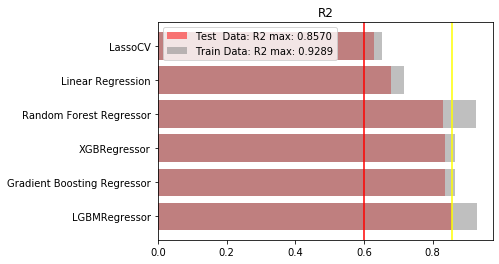

In [89]:
r2_max_test = models_score_test['r2'].max()
r2_max_train = models_score_train['r2'].max()
plt.barh(models_score_test['name'], models_score_test['r2'],
         alpha=0.5, color='red', label=f'Test  Data: R2 max: {r2_max_test:.4f}')
plt.barh(models_score_train['name'], models_score_train['r2'],
         alpha=0.5, color='grey', label=f'Train Data: R2 max: {r2_max_train:.4f}')
plt.title('R2')
plt.legend()
plt.axvline(0.6, color='red')
plt.axvline(r2_max_test, color='yellow')
plt.show()

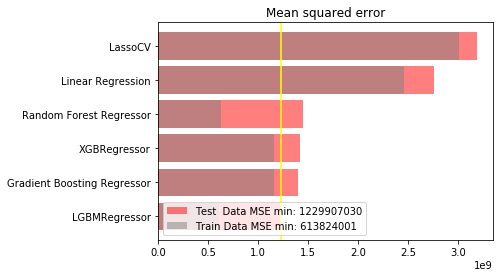

In [90]:
mse_min_test = models_score_test['mse'].min()
mse_min_train = models_score_train['mse'].min()
plt.barh(models_score_test['name'], models_score_test['mse'],
         alpha=0.5, color='red', label=f'Test  Data MSE min: {mse_min_test:.0f}')
plt.barh(models_score_train['name'], models_score_train['mse'],
         alpha=0.5, color='grey', label=f'Train Data MSE min: {mse_min_train:.0f}')
plt.title('Mean squared error')
plt.legend(loc=3)
plt.axvline(mse_min_test, color='yellow')
plt.show()

In [91]:
best_model = models_dict['LGBMRegressor']

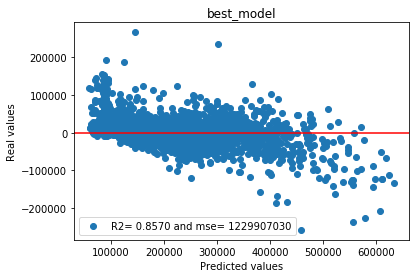

In [92]:
model_test(best_model, 'best_model')

## Output Files

In [93]:
test['Price'] = best_model.predict(test[features])

In [94]:
test[['Id', 'Price']].to_csv('DRubtsov_predictions.csv', index=None)